# Cat vs Dog Image Classification With Transfer Learning Using Keras MobileNetv2

# Importing Libraries

In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? True


# Downloading Dataset

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
!tar -xvf images.tar.gz -C data
!tar -xvf annotations.tar.gz -C data

In [4]:
def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        image_name += '.jpg'
        if image_name[0].lower() != image_name[0]:
            class_name = 'cat'
        else:
            class_name = 'dog'
        annotations[image_name] = class_name
    
    return annotations, i + 1

In [5]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, train_count = get_annotations('data/annotations/trainval.txt')
test_annot, test_count = get_annotations('data/annotations/test.txt')

In [6]:
print(f'Train count {train_count} \nTest count {test_count}')

Train count 3680 
Test count 3669


# Get Random Batch

In [7]:
def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)

    indices = np.random.choice(total_examples, size=batch_size, replace=False)
    
    images= []
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images =[]
    
    for i, idx in enumerate(indices):
        image_path = os.path.join('data/images/', all_keys[idx])
        image = tf.keras.preprocessing.image.load_img(
            image_path, target_size=(128, 128))
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[idx]]]
        images.append(image)
        
    return x, y, images

In [8]:
def display_examples(x, y, p, images, index_to_class):
    if len(images) != 8:
        print('Need 8 examples')
        return None

    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        gt = int(np.squeeze(y[i]) > 0.5)
        pred = int(np.squeeze(p[i]) > 0.5)
        col = 'green' if gt == pred else 'red'
        plt.xlabel(index_to_class[pred], color=col)
    return plt

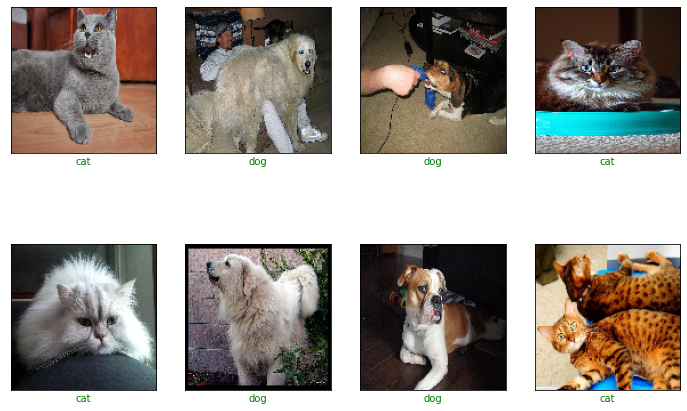

In [9]:
x, y, images = get_random_batch(train_annot, batch_size=8)
display_examples(x, y, y, images, index_to_class).show()

# Creating Model

In [10]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False, pooling='avg', 
    weights='imagenet', input_shape=(128, 128, 3))
mnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(mnet)
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [12]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Training Model

In [13]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield x, y

In [14]:
batch_size = 256
steps_per_epoch = int(train_count/batch_size)
validation_steps = int(test_count/batch_size)

In [15]:
hist = model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    validation_steps = validation_steps,
    steps_per_epoch = steps_per_epoch,
    epochs = 5)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
14/14 [==============================] - 35s 2s/step - loss: 0.7208 - accuracy: 0.6397 - val_loss: 0.2921 - val_accuracy: 0.9099
Epoch 2/5
14/14 [==============================] - 30s 2s/step - loss: 0.3211 - accuracy: 0.8577 - val_loss: 0.1642 - val_accuracy: 0.9531
Epoch 3/5
14/14 [==============================] - 31s 2s/step - loss: 0.2080 - accuracy: 0.9299 - val_loss: 0.1222 - val_accuracy: 0.9662
Epoch 4/5
14/14 [==============================] - 30s 2s/step - loss: 0.1785 - accuracy: 0.9349 - val_loss: 0.1019 - val_accuracy: 0.9682
Epoch 5/5
14/14 [==============================] - 31s 2s/step - loss: 0.1326 - accuracy: 0.9573 - val_loss: 0.0982 - val_accuracy: 0.9724


# Predictions

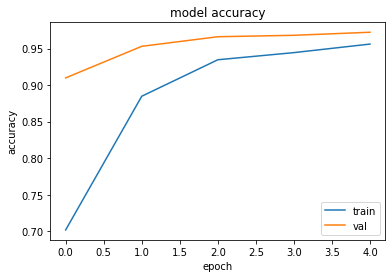

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [17]:
x_test, y_test, images_test = get_random_batch(test_annot, batch_size=1000)
_, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy : {test_acc}')

32/32 [==============================] - 1s 18ms/step - loss: 0.0841 - accuracy: 0.9730
Test accuracy : 0.9729999899864197


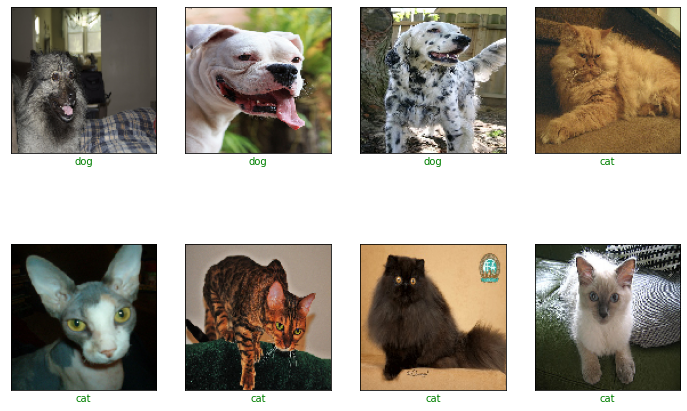

In [18]:
x_test, y_test, images_test = get_random_batch(test_annot, batch_size=8)
x_pred = model.predict(x_test)
display_examples(x_test, y_test, x_pred, images_test, index_to_class).show()